# Setup

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from plotly.express import imshow as imshow_interactive

## Import app modules

In [2]:
import sys
import pathlib

REPO_DIR = pathlib.Path(__name__).resolve().parent.parent
SRC_DIR = str(REPO_DIR / "src")
sys.path.append(SRC_DIR)

In [3]:
from scanplot.io import read_image_rgb
from scanplot.io import dump_coords_csv
from scanplot.plotting import draw_image

In [4]:
from scanplot.core import template_match
from scanplot.core import replace_black_pixels
from scanplot.core import normalize_map
from scanplot.core import image_tresholding, reconstruct_template_mask
from scanplot.core import generalized_hough_transform
from scanplot.core import CoordinatesConverter

In [5]:
from scanplot.view import CoordinatesMapper, DetectorWidget

# Algorithm Pipeline

## Upload plot image and template image

Input data examples can be found in `<REPOSITORY>/datasets/`.

In [6]:
DATA_PATH = pathlib.Path("../datasets/")

In [7]:
PLOT_NUMBER = 66
MARKER_NUMBER = 5

PLOT_PATH = DATA_PATH / "plot_images" / f"plot{PLOT_NUMBER}.png"
TEMPLATE_PATH = (
    DATA_PATH / "marker_images" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"
)

In [8]:
source_image = read_image_rgb(PLOT_PATH)
source_template = read_image_rgb(TEMPLATE_PATH)

image = replace_black_pixels(source_image)
template = replace_black_pixels(source_template)

DEBUG - preprocess.py - replace_black_pixels: Number of black pixels on image: 6472
DEBUG - preprocess.py - replace_black_pixels: Number of black pixels on image: 0


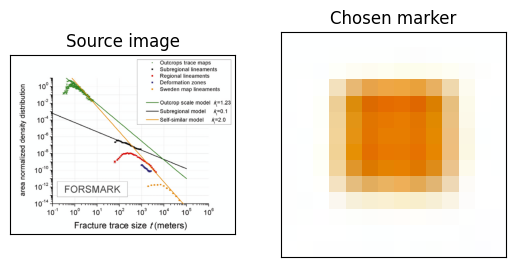

In [9]:
plt.subplot(1, 2, 1)
draw_image(image)
plt.title("Source image")
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
draw_image(template)
plt.title("Chosen marker")
plt.xticks([])
plt.yticks([]);

## Tresholding

DEBUG - process_template.py - image_tresholding: Use Mean tresholding, treshold value = 222


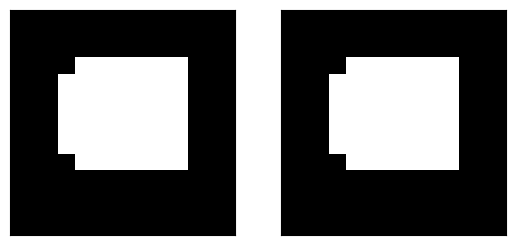

In [10]:
template_mask = image_tresholding(template)
additional_template_mask = reconstruct_template_mask(template_mask)

fig = plt.figure()
plt.subplot(1, 2, 1)
draw_image(template_mask)
plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
draw_image(additional_template_mask)
plt.xticks([]); plt.yticks([]);

## Template matching

Run template matching algorithm and compute convolutoin (or correlatoin) map.

In [11]:
correlation_map, _ = template_match(
    image, template, template_mask, norm_result=True
)
correlation_map_additional, _ = template_match(
    image, template, additional_template_mask, norm_result=True
)

DEBUG - template_match.py - template_match: Correlation map bounds: (0.0, 6.9470396)
DEBUG - template_match.py - template_match: Correlation map was inverted
DEBUG - template_match.py - template_match: Correlation map bounds: (0.0, 6.9470396)
DEBUG - template_match.py - template_match: Correlation map was inverted


## Hough transform

In [12]:
accumulator = generalized_hough_transform(
    image, template, norm_result=True, crop_result=True
)

assert correlation_map.shape == accumulator.shape

## Combine correlation maps

This step combines correlation map obtained by template matching algorithm and accumulator array from Hough Transform.

In [13]:
# correlation_map_combined = correlation_map + 0.7 * correlation_map_additional
# correlation_map_combined = normalize_map(correlation_map_combined)

correlation_map_with_hough = correlation_map + 0.6 * accumulator
correlation_map_with_hough = normalize_map(correlation_map_with_hough)

## Algorithm parameters

The algorithm has 2 parameters:
- Points Number
- Points Density

Learn more about parameters selection in [documentation](https://github.com/adusachev/scanplot/blob/develop/docs/user_manual.md#algorithm-parameters).

In [14]:
detector = DetectorWidget(
    source_image=source_image,
    template=template,
    correlation_map=correlation_map_with_hough
)

In [17]:
fig_size = 8
marker_size = 80
marker_color = "yellow"
marker_type = "*"


detector.main_widget(fig_size, marker_size, marker_color, marker_type)

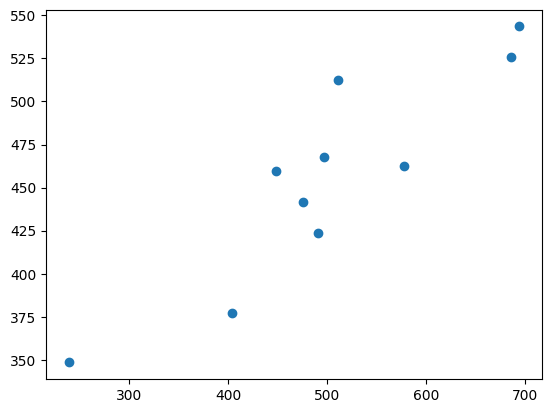

In [16]:
detected_points_px = detector.get_detections()

# points coordinates in pixels (!)
x = detected_points_px[:, 0]
y = detected_points_px[:, 1]
plt.scatter(x, y)

# Convert coordinates

Map pixel coordinates to factual coordinates

In [ ]:
mapper = CoordinatesMapper(source_image)

In [ ]:
mapper.interactive_widget()

Convert pixel coordinates to factual coordinates

In [ ]:
converter = CoordinatesConverter()
converter.import_parameters_from_mapper(mapper)

In [ ]:
x_px = detected_points_px[:, 0]
y_px = detected_points_px[:, 1]

x_factual, y_factual = converter.from_pixel(x_pixel=x_px, y_pixel=y_px)

In [ ]:
plt.scatter(x_factual, y_factual)

Save obtained coordinates in csv

In [ ]:
dump_coords_csv(
    x=x_factual,
    y=y_factual,
    savepath=f"detections_plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.csv"
)